## Librarby Import

In [1]:
import pymongo

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.gaussian_process import kernels,GaussianProcessRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import math,os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import TimeSeriesSplit

import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.width', None)

## Data Fetching

In [17]:
class StockDataPreprocessor:
    def __init__(self, db_name, collection_name, symbol, mongo_uri="mongodb://localhost:27017/"):
        """
        Initializes the MongoDB connection and prepares the collection for the stock data.

        Args:
            db_name (str): Name of the MongoDB database.
            collection_name (str): Name of the collection inside the database.
            symbol (str): The stock symbol to filter the data (e.g., 'NVDA').
            mongo_uri (str): MongoDB connection URI (default is localhost).
        """
        self.mongo_uri = mongo_uri
        self.client = pymongo.MongoClient(self.mongo_uri)
        self.db = self.client[db_name]
        self.collection = self.db[collection_name]
        self.symbol = symbol
        self.df = None
        self.df_test = None

    def fetch_data(self):
        """Fetches stock data from the MongoDB collection and converts it to a Pandas DataFrame."""
        # Fetch the data from MongoDB
        data = self.collection.find({})
        
        # Convert the data to a Pandas DataFrame
        df = pd.DataFrame(list(data))
        
        # Extract the desired stock symbol's technical data
        df_filtered = df[df['symbol'] == self.symbol]
        if not df_filtered.empty:
            # Extract the 'technical_data' field from the filtered data
            self.df = pd.DataFrame(df_filtered['technical_data'].iloc[0])
        else:
            raise ValueError(f"No data found for symbol: {self.symbol}")

    def split_data(self):
        """Splits the data into training and testing datasets."""
        if self.df is not None:
            # Take the latest 2900 rows for training
            self.df = self.df[-3000:-100]  # From -3000 to -100 rows for training

            # Take the rest (last 100 rows) for testing
            self.df_test = self.df[-100:]
        else:
            raise ValueError("Data not loaded. Call fetch_data() first.")

    def get_train_data(self):
        """Returns the training data."""
        if self.df is not None:
            return self.df
        else:
            raise ValueError("Data not loaded or split. Call fetch_data() and split_data() first.")

    def get_test_data(self):
        """Returns the test data."""
        if self.df_test is not None:
            return self.df_test
        else:
            raise ValueError("Test data not available. Call split_data() first.")


## Check Data Integrity

In [18]:
#Compute the missing value ratio 
def missing_values(df):
    missing_data = ((df.isnull().sum())/len(df))
    missing_data = missing_data[missing_data.values > 0].sort_values()
    if missing_data.empty:
        print('No missing values')    
    else:
        #Visualize the missing value ratio 
        fig = plt.figure(figsize=(5,5), dpi = 100)
        sns.barplot(x = missing_data.index, y = missing_data.values) 
        plt.xticks(rotation=90)
        plt.title('Features Missing Ratio')
        plt.show()
    

## Data Processing

In [4]:
class DataPreprocessor:
    def __init__(self, exclude_columns=None):
        """
        Initializes the DataPreprocessor with the columns to exclude from log transformation.

        Args:
            exclude_columns (list): List of numeric columns to exclude from log transformation.
        """
        self.exclude_columns = exclude_columns if exclude_columns else ['MACD', 'MACD_SIGNAL', 'MACD_HIST']
        self.ohe = OneHotEncoder(drop='first')  # OneHotEncoder for categorical columns
    
    def preprocess(self, df):
        """
        Preprocess the dataframe by performing the following steps:
        - Drop 'date' column and rows with missing values
        - Convert alert-related columns to categorical types
        - Log-transform numeric columns except for excluded columns
        - One-hot encode categorical columns
        - Add a timestamp column

        Args:
            df (pd.DataFrame): The input dataframe to preprocess.

        Returns:
            pd.DataFrame: The preprocessed dataframe.
        """
        # Step 1: Drop 'date' column and handle missing values
        df = df.drop(columns=['date'], errors='ignore')  # Avoids error if 'date' is missing
        df = df.dropna()

        # Step 2: Convert relevant columns to category
        df["CandleStickType"] = df["CandleStickType"].astype('category')
        df["Incremental_High"] = df["Incremental_High"].astype('category')
        df["MACD_GOLDEN_CROSS"] = df["MACD_GOLDEN_CROSS"].astype('category')

        alert_columns = df.columns[df.columns.str.contains('Alert')]
        for column in alert_columns:
            df[column] = df[column].astype('category')

        # Step 3: Log transform numeric columns, excluding specified columns
        numeric_df = df.select_dtypes(include=['float64', 'int64'])
        cols_to_transform = [col for col in numeric_df.columns if col not in self.exclude_columns]
        numeric_df[cols_to_transform] = np.log1p(numeric_df[cols_to_transform])

        # Concatenate excluded numeric columns with the transformed ones
        numeric_df = pd.concat([df[self.exclude_columns], numeric_df[cols_to_transform]], axis=1)

        # Reset index for the numeric DataFrame
        numeric_df = numeric_df.reset_index(drop=True)

        # Step 4: One-hot encode categorical columns
        categorical_df = df.select_dtypes(include=['category'])
        encoded_df = pd.DataFrame(self.ohe.fit_transform(categorical_df).toarray(), 
                                columns=self.ohe.get_feature_names_out(categorical_df.columns))

        # Step 5: Concatenate numeric and encoded categorical data
        df = pd.concat([numeric_df, encoded_df], axis=1)

        # Step 6: Add timestamp column
        df['timestamp'] = df.index

        return df
    


## Machine Learning Class & Functions

### Base Model

MSE Baseline Prediction score: 0.16937046


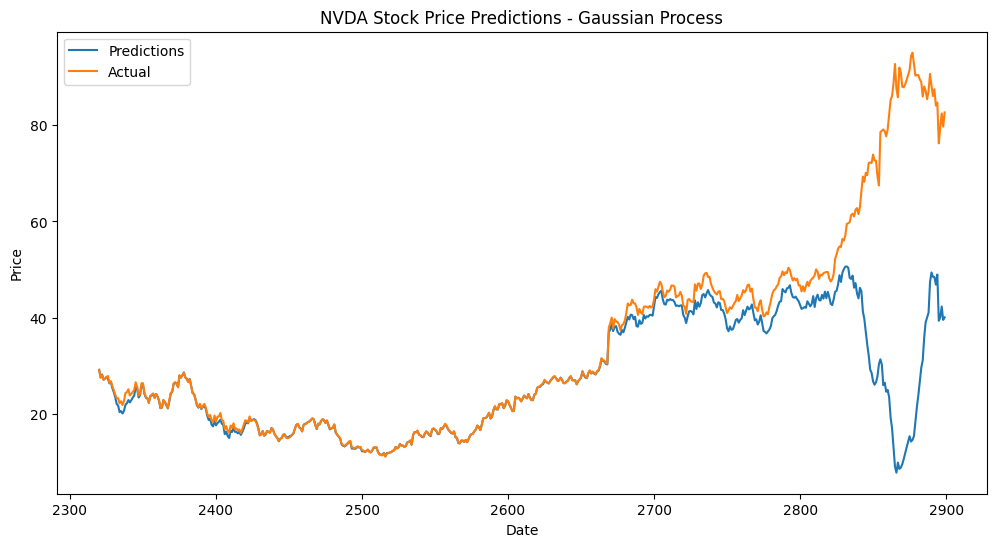

In [6]:
def base_score(df):

    X = df.copy()
    X = X.drop(['timestamp'], axis=1)
    
    # Split data into training and testing sets
    train_size = int(len(df) * 0.8)
    X_train = X[:train_size].drop('close', axis=1)
    y_train_data = X['close'][:train_size]
    X_test = X[train_size:].drop('close', axis=1)
    y_test_data = X['close'][train_size:]
    
    # Train the model
    kernel = kernels.RBF()
    model = GaussianProcessRegressor(kernel=kernel, random_state=42)
    model.fit(X_train, y_train_data)

    # Make predictions on the testing set
    predictions = model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test_data, predictions)
    
    # Plot predictions and actual stock prices
    plt.figure(figsize=(12, 6))
    plt.plot(X_test.index, np.expm1(predictions), label='Predictions')
    plt.plot(X_test.index, np.expm1(y_test_data), label='Actual')
    plt.title('NVDA Stock Price Predictions - Gaussian Process')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    return mse

print(f"MSE Baseline Prediction score: {base_score(df):.8}")

### Transformer Model

#### Data Loading

In [16]:
class TimeSeriesDataset(Dataset):
  def __init__(self, dataframe, window_size):

    self.window_size = window_size
    
    # Convert dataframe to tensors
    features = torch.tensor(dataframe.drop(['close'],axis=1).values, dtype=torch.float32)
    targets = torch.tensor(dataframe['close'].values, dtype=torch.float32)

    self.windows = []
    self.targets = []
    
    # Genearate windows
    max_num_windows = len(features) - self.window_size 
    
    for i in range(max_num_windows):
      
      # Extract window data and target
      window_data_tensor = features[i:i + self.window_size]
      target = targets[i + self.window_size] # Predict the next day's close price
      
      # Append to the list
      self.windows.append(window_data_tensor)
      self.targets.append(target)

  def __len__(self):
    return len(self.windows)

  def __getitem__(self, idx):
    if idx >= len(self.windows):
      raise IndexError("Index out of range")
    return self.windows[idx], self.targets[idx]

#### Model Architecture Class

In [8]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout=0.1, max_len=256):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

class TransformerModel(nn.Module):
  def __init__(self, input_dim, d_model, nhead, num_encoder_layers,
                num_decoder_layers, dim_feedforward, dropout):

    super(TransformerModel, self).__init__()
    self.linear_encoder = nn.Linear(input_dim, d_model)
    self.pos_encoder = PositionalEncoding(d_model, dropout)
    self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dim_feedforward),
      nn.BatchNorm1d(dim_feedforward),
      nn.ReLU(),
      nn.Linear(dim_feedforward, d_model),
      nn.BatchNorm1d(d_model),
      nn.ReLU())
    self.linear_decoder = nn.Linear(d_model, 1)
    self.d_model = d_model

  def forward(self, x):
    # Validate h3_indices
        
    # Encode the input features
    x = self.linear_encoder(x) * math.sqrt(self.d_model)
    # Add positional encoding to input features
    x = self.pos_encoder(x)
    # Transformer expects inputs in the shape (S, N, E) -> (sequence_length, batch_size, d_model)
    x = x.transpose(0, 1)
    # Pass through the transformer
    transformer_output = self.transformer(x, x)

    # Apply feedforward network with BatchNorm1d
    batch_size, seq_len, feature_dim = transformer_output.size()
    transformer_output = transformer_output.contiguous().view(-1, feature_dim)
    # Apply feedforward network
    transformer_output = self.ffn(transformer_output)
    # Use the last time step for each sequence in the batch
    transformer_output = transformer_output.view(seq_len, batch_size, self.d_model).transpose(0, 1).contiguous()
    output = self.linear_decoder(transformer_output[-1])
    return output.squeeze(1)

def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)
    if m.bias is not None:
      nn.init.zeros_(m.bias)


#### Train Class

In [9]:
class TimeSeriesTrainer:
    def __init__(self, model, epochs, criterion, optimizer, verbose=True):
        """
        Args:
            model (torch.nn.Module): The PyTorch model to train.
            epochs (int): Number of epochs to train.
            criterion (torch.nn.Module): The loss function.
            optimizer (torch.optim.Optimizer): The optimizer.
            scheduler (optional): Learning rate scheduler (if any).
        """
        self.l1_lambda = 0.001
        self.l2_lambda = 0.001
        
        self.model = model
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.verbose = verbose
        self.model_path = '/Users/yiukitcheung/Documents/Projects/Stocks/models/'
        
    def train(self, train_dataloader, epoch, device):
        self.model.train()

        # Initialize accumulators
        total_loss = 0
        train_pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader),
                        desc=f"Epoch {epoch + 1}/{self.epochs}")

        # Train over batches
        for _, (x_batch, y_batch) in train_pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            self.optimizer.zero_grad()

            # Predict
            y_pred = self.model(x_batch)

            # Compute loss
            # Calculate regularization terms
            l1_regularization = torch.tensor(0.).to(device)
            l2_regularization = torch.tensor(0.).to(device)
            for param in self.model.parameters():
                l1_regularization += torch.norm(param, 1)
                l2_regularization += torch.norm(param, 2)

            # Compute Loss
            loss = self.criterion(y_pred, y_batch) + self.l1_lambda * l1_regularization + self.l2_lambda * l2_regularization
            loss.backward()
            self.optimizer.step()

            # Accumulate loss
            total_loss += loss.item()

            # Update progress bar
            train_pbar.set_postfix({'Batch Loss': f"{loss.item():.4f}"})

        # Calculate average loss
        avg_train_loss = total_loss / len(train_dataloader)

        return avg_train_loss

    def validate(self, test_dataloader, device):
        self.model.eval()

        # Initialize accumulators
        total_loss = 0

        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Validating"):
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                # Predict
                y_pred = self.model(x_batch)

                # Compute loss
                batch_loss = self.criterion(y_pred, y_batch)
                total_loss += batch_loss.item()

        # Compute average loss
        avg_val_loss = total_loss / len(test_dataloader)



        return avg_val_loss

    def run(self, df, window_size, batch_size, device):
        """
        Run the training and validation over multiple folds.
        Args:
            df (pd.DataFrame): Dataframe containing the data.
            window_size (int): The size of the sliding window.
            batch_size (int): Batch size for dataloaders.
            device (torch.device): The device to train on.
        """
        tscv = TimeSeriesSplit(n_splits=4)
        folds_val_results = {}
        folds_train_results = {}

        # Expanding Window Cross-Validation Folds
        for fold, (train_index, val_index) in enumerate(tscv.split(df)):
            train_df = df.iloc[train_index]
            val_df = df.iloc[val_index]

            # Create datasets and dataloaders
            train_dataset = TimeSeriesDataset(train_df, window_size=window_size)
            val_dataset = TimeSeriesDataset(val_df, window_size=window_size)

            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
            val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # Initialize results containers for each fold
            fold_val_results = []
            fold_train_results = []

            # Train and validate for each epoch
            for epoch in range(self.epochs):
                avg_train_loss = self.train(train_dataloader, epoch, device)
                avg_val_loss = self.validate(val_dataloader, device)
                
                if self.verbose:
                    print(f"Fold {fold+1}: Epoch [{epoch + 1}/{self.epochs}], Train Loss: {avg_train_loss:.4f}")
                    print(f"Fold {fold+1}: Epoch [{epoch + 1}/{self.epochs}], Val Loss: {avg_val_loss:.4f}")

                # Record validation and training loss
                fold_val_results.append(avg_val_loss)
                fold_train_results.append(avg_train_loss)

            # Store results for each fold
            folds_val_results[fold] = fold_val_results
            folds_train_results[fold] = fold_train_results

        # Store the model
        self.save_model()
        
        return folds_train_results, folds_val_results
    
    def save_model(self):
        save_path = os.path.join(self.model_path+'_NVDA.pth')
        torch.save(self.model.state_dict(),save_path)
    
    def viz_performance(self, train, eval):
        # Assuming folds_train_results and folds_val_results are populated as in your example
        # Create a new figure
        fig = go.Figure()

        # Define a limited set of contrasting colors
        colors = ['blue', 'green', 'red', 'purple']

        # Number of folds
        folds = len(train)

        # Plot each fold
        for i in range(folds):
            color = colors[i // 4]  # Cycle through colors every 4 folds
            epochs = np.arange(i * len(train[i]), (i + 1) * len(train[i]))
            
            fig.add_trace(go.Scatter(x=epochs, y=train[i], mode='lines', name='Train' if i == 0 else None,
                                    line=dict(color=color, dash='solid'), showlegend=(i == 0)))
            fig.add_trace(go.Scatter(x=epochs, y=eval[i], mode='lines', name='Eval' if i == 0 else None,
                                    line=dict(color=color, dash='dash'), showlegend=(i == 0)))

            # Add vertical line to indicate fold boundary
            if i < folds - 1:
                fig.add_shape(type="line", x0=(i + 1) * len(train[i]) - 0.5,
                                y0=min(min(train[i]), min(eval[i])),
                                x1=(i + 1) * len(train[i]) - 0.5,
                                y1=max(max(train[i]), max(eval[i])),
                                line=dict(color="black", dash="dash"))

            # Add text annotation to indicate fold number
            fig.add_annotation(x=(i + 0.5) * len(train[i]),
                                y=max(max(train[i]), max(eval[i])),
                                text=f"Fold {i + 1}", showarrow=False, yshift=10)

        # Add titles and labels
        fig.update_layout(
            title='Training and Evaluation Metrics',
            xaxis_title='Epochs',
            yaxis_title='Metric',
            legend_title='Legend',
            template='plotly_white'
        )

        # Show the plot
        fig.show()

In [13]:
class test_model:

    def __init__(self,df,model,device):
        self.df = df
        self.model = model
        self.device = device
        self.window_size = 30

    def predict(self):
        test_dataset = TimeSeriesDataset(self.df, window_size=self.window_size)
        test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)
        self.model.eval()        
        
        all_pred = []
        all_targets = []
        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Predicting..."):
                inputs, targets = batch
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Predict
                y_pred = self.model(inputs)
                
                # Convert to numpy arrays
                y_pred = y_pred.cpu().numpy()
                targets = targets.cpu().numpy()
                
                # Append to the list
                all_pred.append(y_pred)
                all_targets.append(targets) 
            
            # Concatenate all the predictions and targets
            all_pred = np.concatenate(all_pred, axis=0)
            all_targets = np.concatenate(all_targets, axis=0)
            
        return all_pred, all_targets
    
# Instantiate the prediction model
model = TransformerModel(input_dim = df.shape[1]-1, d_model=64, nhead=4, num_encoder_layers=2,
                        num_decoder_layers=2, dim_feedforward=256, dropout=0.1)

model.load_state_dict(torch.load('/Users/yiukitcheung/Documents/Projects/Stocks/models/_NVDA.pth'))

device = torch.device("cpu")
model.to(device)

pre_processed_df_test = preprocessor.preprocess(df_test)

# Ensure that the test data has the same columns as the training data
missing_cols = set(df.columns) - set(pre_processed_df_test.columns)

for col in missing_cols:
    pre_processed_df_test[col] = 0

tester = test_model(pre_processed_df_test, model, device)
predictions, targets = tester.predict()

Predicting...: 100%|██████████| 70/70 [00:00<00:00, 732.46it/s]


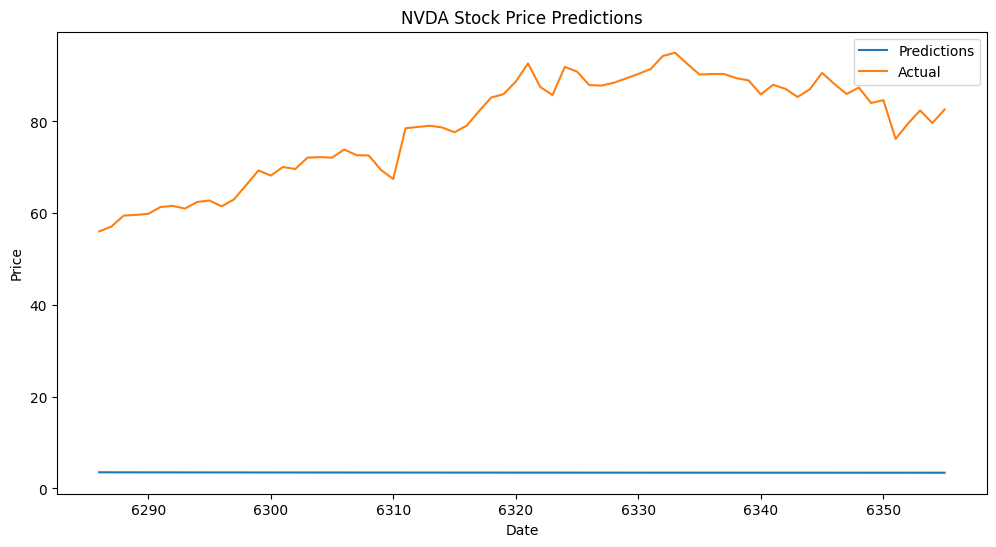

In [15]:
# Plot predictions and actual stock prices for the last 100 days
plt.figure(figsize=(12, 6))
plt.plot(df_test.index[-70:], np.expm1(predictions), label='Predictions')  # Take the last 100 predictions
plt.plot(df_test.index[-70:], np.expm1(targets), label='Actual')       # Take the last 100 actuals
plt.title('NVDA Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Machine Learning Pipeline

In [ ]:
# Initialize the class with the database and collection details
prepare_data = StockDataPreprocessor(db_name="stock_data_db",
                                    collection_name="stock_data", 
                                    symbol="NVDA")

# Fetch data from MongoDB
prepare_data.fetch_data()
# Split the data into training and testing datasets
prepare_data.split_data()

# Retrieve training and test data
train_data = prepare_data.get_train_data()
test_data = prepare_data.get_test_data()

# Initialize the preprocessor with columns to exclude from log transformation
preprocessor = DataPreprocessor(exclude_columns=['MACD', 'MACD_SIGNAL', 'MACD_HIST'])
processed_train_data = preprocessor.preprocess(train_data)

# Define model, criterion, optimizer, and device

# Set device to apple silicon if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found.")
else:
    print ("MPS device not found.")

# Initialize the model
model = TransformerModel(input_dim= processed_train_data.shape[1]-1, d_model=64, nhead=4, num_encoder_layers=2,
                        num_decoder_layers=2, dim_feedforward=256, dropout=0.1)

# Apply weight initialization                          
model.apply(init_weights)

# Set model to device
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create the trainer object
trainer = TimeSeriesTrainer(model=model, 
                            epochs=10,
                            criterion=criterion,
                            optimizer=optimizer,
                            verbose=False)

# Run training with cross-validation
folds_train_results, folds_val_results = trainer.run(df=processed_train_data, 
                                                    window_size=30, 
                                                    batch_size=32, 
                                                    device=device)